# Load libraries and data

In [ ]:
library(DESeq2)
library(enrichplot)
library(clusterProfiler)
library(ggplot2)
library(org.Hs.eg.db)
library(gridExtra)
library(grid)
source('../utils/utils.R')

In [2]:
# load non-filtered deseq results (for PlotPair)
brain_deseq_2025 = readRDS('../../rds/NGS-20250519/deseq2_brain_all comparison.rds')
gut_deseq_2025 = readRDS('../../rds/NGS-20250519/deseq2_gut_MLB2_mock.rds')

In [3]:
#load genes for all analysis
genes <- readRDS('../../rds/NGS-20250519/genes.rds')
genes[1:2,]

,chr,start,end,strand,gene_id,gene_name,gene_biotype
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
ENSG00000279928,1,182696,184174,+,ENSG00000279928,DDX11L17,unprocessed_pseudogene
ENSG00000228037,1,2581560,2584533,+,ENSG00000228037,NA,lncRNA


### PlotPair - tissue

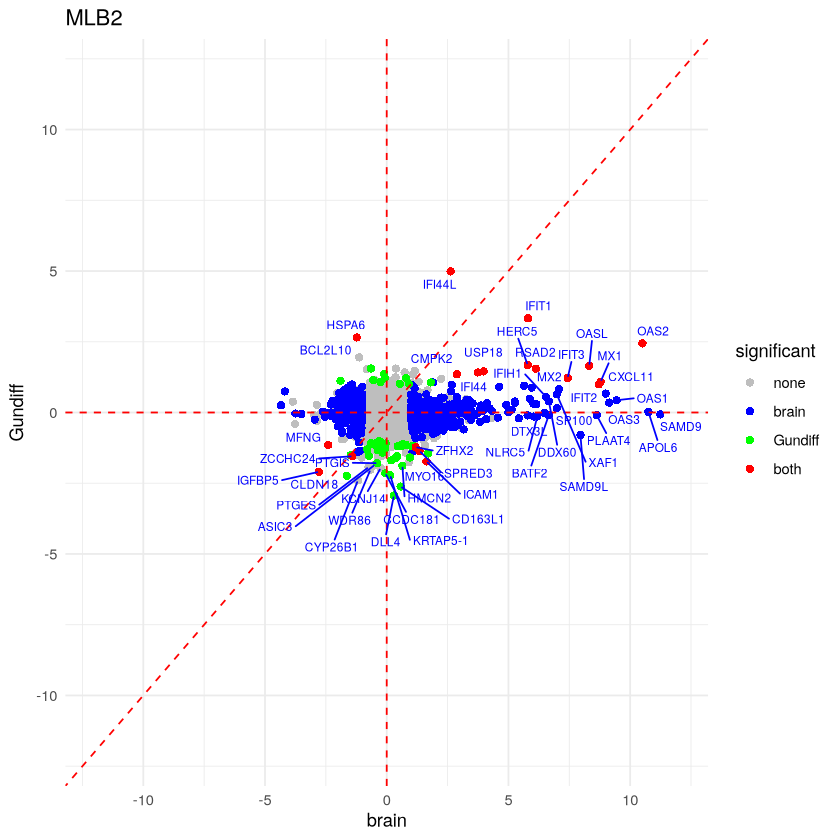

In [4]:
z=plotPair(brain_deseq_2025[["MLB2/mock"]],
           gut_deseq_2025[["MLB2/mock"]],
           xlab='brain',ylab='Gundiff',title='MLB2',genes=genes)
z

In [5]:
ggsave("plotpair_MLB2_brain_vs_gundiff354.pdf", plot = z, width = 10, height = 8, dpi = 300)

# Create dataset for up- and downregulated genes for enrichment analysis (cnetplot, GO enrichment, KEGG and REACTOME)

In [8]:
# load filtered deseq data (f <- x$padj < 0.05 & abs(x$log2FoldChange) > 1)
deseq_gut_MLB2 = readRDS('../../rds/NGS-20250519/deg_0.05_1/deseq_gut_MLB2_mock.rds')

In [21]:
#load filtered brain data for comparison with gut
deseq_brain_MLB2 = readRDS('../../rds/NGS-20250519/deg_0.05_1/deseq_brain_MLB2_mock.rds')

In [9]:
#for enrichGO,CompareCluster
MLB2_up <- deseq_gut_MLB2$gene_id[deseq_gut_MLB2$log2FoldChange > 1 & deseq_gut_MLB2$padj < 0.05]
MLB2_down <- deseq_gut_MLB2$gene_id[deseq_gut_MLB2$log2FoldChange < -1 & deseq_gut_MLB2$padj < 0.05]

In [10]:
#for enrichKEGG, encrichPathway
MLB2_up_entrez   <- bitr(MLB2_up,   fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)
MLB2_down_entrez <- bitr(MLB2_down, fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(MLB2_down, fromType = "ENSEMBL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“2.7% of input gene IDs are fail to map...”


# Cnetplot

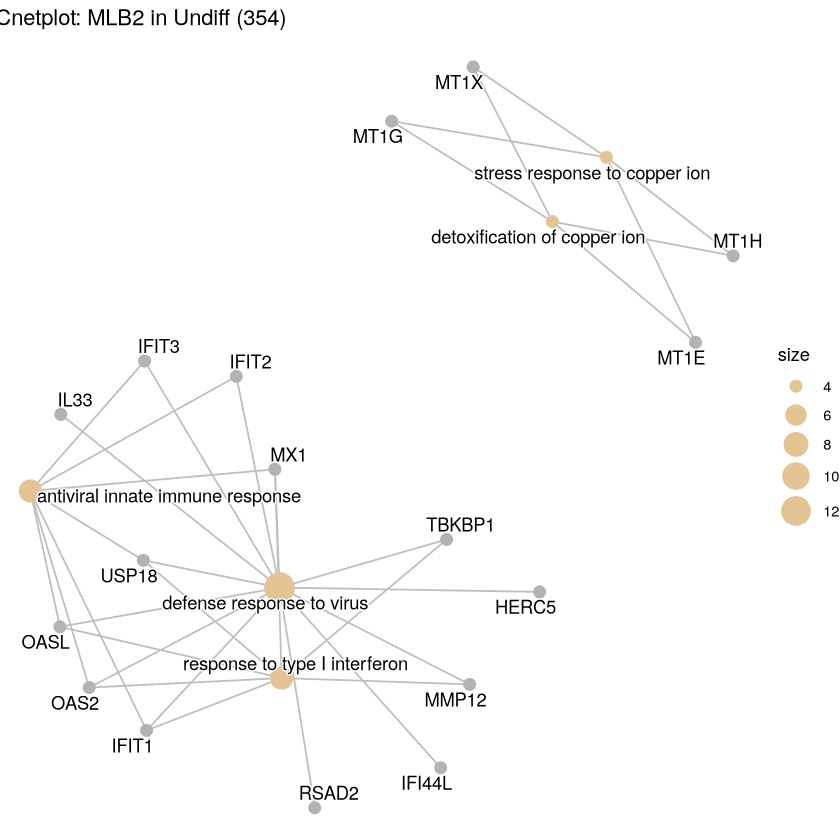

In [14]:
# enrichGO object (ego) for all genes for MLB2 (up and down) 
ego_MLB2 <- enrichGO(
  gene          = deseq_gut_MLB2$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",       # или "SYMBOL", если это символы
  ont           = "BP",
  pAdjustMethod = "BH",
  qvalueCutoff  = 0.05,
  readable      = TRUE
)

# Визуализация
p <- cnetplot(ego_MLB2, categorySize = "pvalue") +
     ggtitle("Cnetplot: MLB2 in Undiff (354)")
p
ggsave("Cnetplot_MLB2_Undiff_354.pdf", plot = p, width = 12, height = 12)

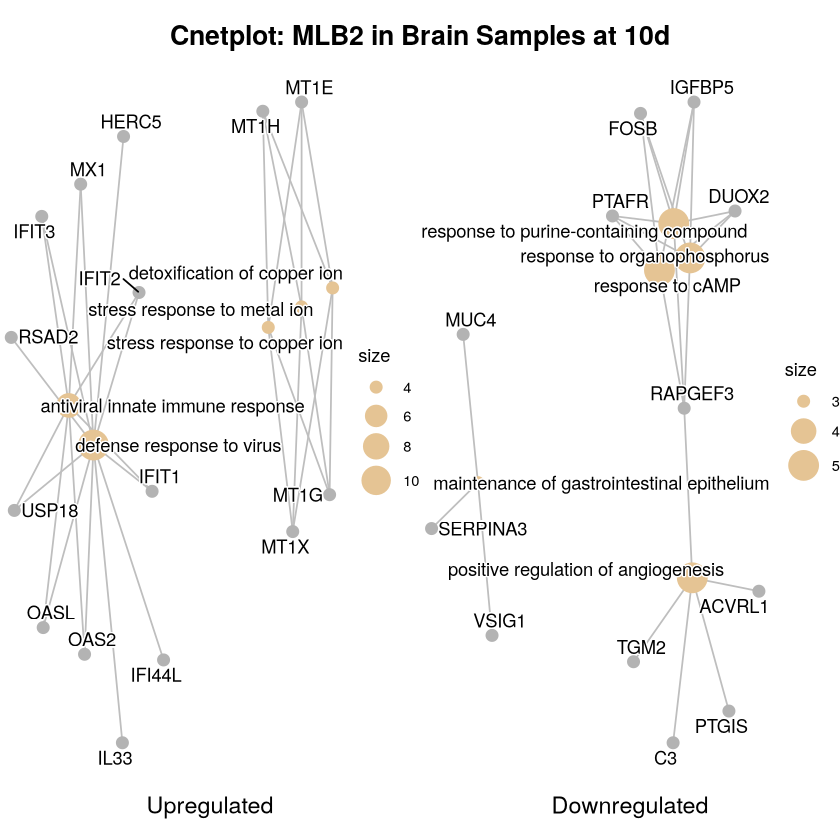

In [15]:
#MLB2_up <- deseq_b_MLB2$gene_id[deseq_b_MLB2$log2FoldChange > 1 & deseq_b_MLB2$padj < 0.05]
#MLB2_down <- deseq_b_MLB2$gene_id[deseq_b_MLB2$log2FoldChange < -1 & deseq_b_MLB2$padj < 0.05]

# GO-анализ
MLB2_ego_up <- enrichGO(gene = MLB2_up,
                        OrgDb = org.Hs.eg.db,
                        keyType = "ENSEMBL",
                        ont = "BP",
                        pAdjustMethod = "BH",
                        qvalueCutoff = 0.05,
                        readable = TRUE)

MLB2_ego_down <- enrichGO(gene = MLB2_down,
                          OrgDb = org.Hs.eg.db,
                          keyType = "ENSEMBL",
                          ont = "BP",
                          pAdjustMethod = "BH",
                          qvalueCutoff = 0.05,
                          readable = TRUE)

# Построение cnetplot с подписями генов и GO-терминов
plot_MLB2_up <- cnetplot(MLB2_ego_up, categorySize = "pvalue", node_label = "all")
plot_MLB2_down <- cnetplot(MLB2_ego_down, categorySize = "pvalue", node_label = "all")

# Подписи под графиками
label_MLB2_up <- textGrob("Upregulated", gp = gpar(fontsize = 14))
label_MLB2_down <- textGrob("Downregulated", gp = gpar(fontsize = 14))

# Строка графиков
plots_row <- arrangeGrob(
  plot_MLB2_up, plot_MLB2_down,
  ncol = 2
)

# Строка подписей
labels_row <- arrangeGrob(
  label_MLB2_up, label_MLB2_down,
  ncol = 2
)

# Заголовок
title <- textGrob("Cnetplot: MLB2 in Brain Samples at 10d", gp = gpar(fontsize = 16, fontface = "bold"))

# Финальная компоновка
grid.arrange(
  title,
  plots_row,
  labels_row,
  ncol = 1,
  heights = c(0.5, 5, 0.5)
)


In [16]:
# Фильтрация DEG
#MLB2_up <- deseq_b_MLB2$gene_id[deseq_b_MLB2$log2FoldChange > 1 & deseq_b_MLB2$padj < 0.05]
#MLB2_down <- deseq_b_MLB2$gene_id[deseq_b_MLB2$log2FoldChange < -1 & deseq_b_MLB2$padj < 0.05]

# GO-анализ
MLB2_ego_up <- enrichGO(gene = MLB2_up,
                        OrgDb = org.Hs.eg.db,
                        keyType = "ENSEMBL",
                        ont = "BP",
                        pAdjustMethod = "BH",
                        qvalueCutoff = 0.05,
                        readable = TRUE)

MLB2_ego_down <- enrichGO(gene = MLB2_down,
                          OrgDb = org.Hs.eg.db,
                          keyType = "ENSEMBL",
                          ont = "BP",
                          pAdjustMethod = "BH",
                          qvalueCutoff = 0.05,
                          readable = TRUE)

# Построение cnetplot с названиями
plot_MLB2_up <- cnetplot(MLB2_ego_up, categorySize = "pvalue", node_label = "all")
plot_MLB2_down <- cnetplot(MLB2_ego_down, categorySize = "pvalue", node_label = "all")

# Подписи
label_MLB2_up <- textGrob("Upregulated", gp = gpar(fontsize = 14))
label_MLB2_down <- textGrob("Downregulated", gp = gpar(fontsize = 14))

# Компоновка
plots_row <- arrangeGrob(plot_MLB2_up, plot_MLB2_down, ncol = 2)
labels_row <- arrangeGrob(label_MLB2_up, label_MLB2_down, ncol = 2)
title <- textGrob("Cnetplot: MLB2 in Undiff Duo354", gp = gpar(fontsize = 16, fontface = "bold"))
final_plot <- arrangeGrob(title, plots_row, labels_row, ncol = 1, heights = c(0.5, 5, 0.5))

# Сохранение в PDF
pdf("08_cnetplot_Undiff_Duo354_MLB2_up&down.pdf", width = 16, height = 8)  # Размеры можно изменить при необходимости
grid.draw(final_plot)
dev.off()


pdf 
  2

# GO Enrichment: Dotplot (compareCluster)

In [30]:
g_go = compareCluster(deseq_gut_MLB2,
                       fun='enrichGO',
                       universe      = genes,
                       pAdjustMethod = "BH",
                       ont='ALL',
                       OrgDb = 'org.Hs.eg.db',
                       keyType = 'ENSEMBL')

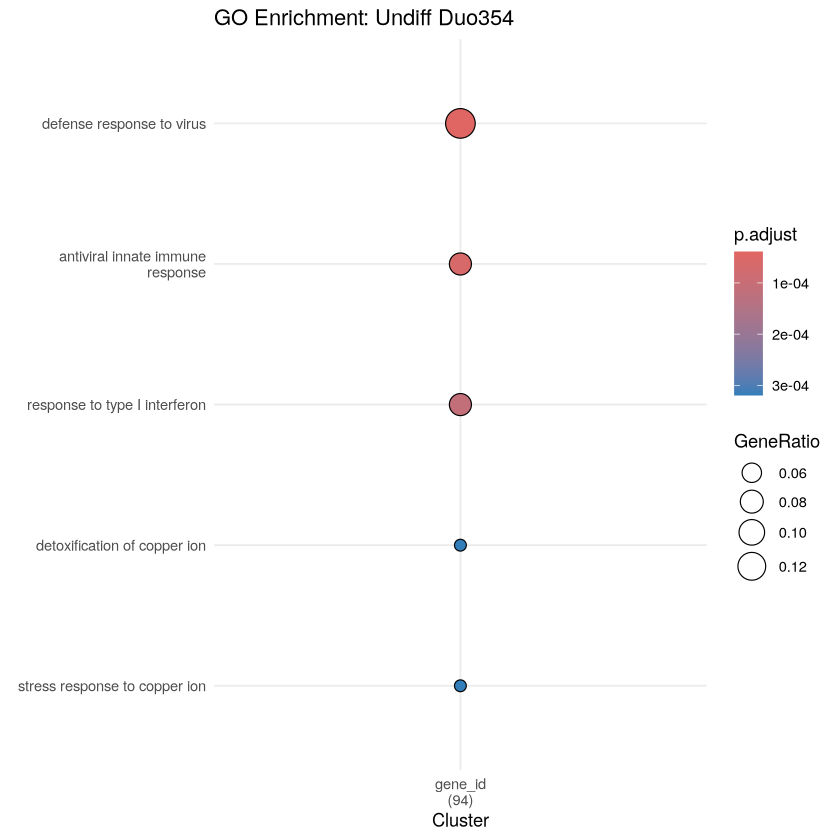

In [19]:
dotplot(g_go) + 
  ggplot2::theme_minimal() + 
  ggplot2::ggtitle("GO Enrichment: Undiff Duo354")

In [33]:
plot <- dotplot(g_go) + 
  ggplot2::theme_minimal() + 
  ggplot2::ggtitle("GO Enrichment in Undiff Duo354")
ggsave("07_GO Enrichment in Undiff Duo354.pdf", plot, width = 12, height = 8)

In [29]:
gene_clusters <- list(
  deseq_gut_MLB2 = deseq_gut_MLB2,
  deseq_brain_MLB2 = deseq_brain_MLB2
)

compare_MLB2_tissue <- compareCluster(
  geneCluster   = gene_clusters,
  fun           = "enrichGO",
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  universe      = genes,  # <- ваш список всех протеин-кодирующих генов
  qvalueCutoff  = 0.05
)


Warning message in compareCluster(geneCluster = gene_clusters, fun = "enrichGO", :
“No enrichment found in any of gene cluster, please check your input...”


In [23]:
plot2 <- dotplot(compare_MLB2_tissue) + 
  ggplot2::theme_minimal() + 
  ggplot2::ggtitle("GO Enrichment of MLB2 in undiff Duo354 and brain")
ggsave("07_GO Enrichment of MLB2 in undiff and brain.pdf", plot2, width = 20, height = 8)

ERROR: Error: unable to find an inherited method for function ‘dotplot’ for signature ‘object = "NULL"’


# KEGG Pathway Enrichment (clusterProfiler)

In [24]:
#library(clusterProfiler)
#library(org.Hs.eg.db)

# KEGG требует ENTREZ ID
#MLB2_up_entrez <- bitr(MLB2_up, fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)

# KEGG enrichment
MLB2_kegg_up <- enrichKEGG(gene         = MLB2_up_entrez$ENTREZID,
                        organism     = 'hsa',  # Homo sapiens
                        pAdjustMethod = "BH",
                        qvalueCutoff = 0.05)

# Просмотр результатов
head(MLB2_kegg_up)


Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



,category,subcategory,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04978,Organismal Systems,Digestive system,hsa04978,Mineral absorption,4/20,61/9392,0.06557377,30.79344,10.783911,7.219308e-06,0.0004403778,0.0004179599,4496/4493/4495/4501,4
hsa05160,Human Diseases,Infectious disease: viral,hsa05160,Hepatitis C,4/20,159/9392,0.02515723,11.81384,6.352749,3.101403e-04,0.0086970621,0.0082543299,4599/91543/4939/3434,4
hsa05164,Human Diseases,Infectious disease: viral,hsa05164,Influenza A,4/20,173/9392,0.02312139,10.85780,6.045275,4.277244e-04,0.0086970621,0.0082543299,4599/90865/91543/4939,4
hsa05162,Human Diseases,Infectious disease: viral,hsa05162,Measles,3/20,139/9392,0.02158273,10.13525,5.012350,3.007213e-03,0.0458600031,0.0435254559,4599/4939/3310,3


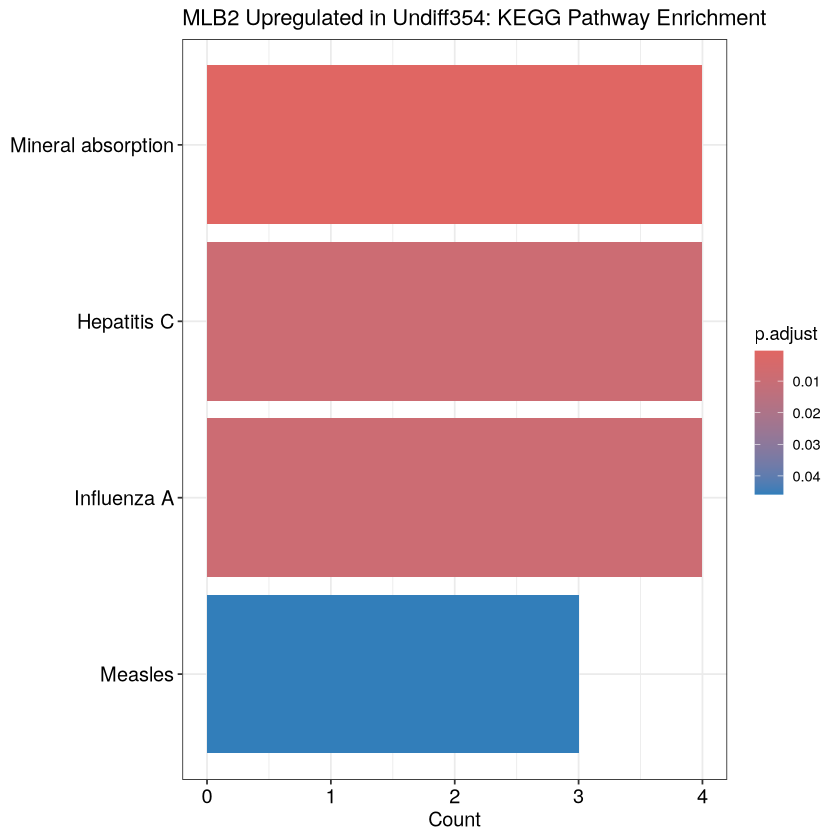

In [25]:
barplot(MLB2_kegg_up, showCategory = 10, title = "MLB2 Upregulated in Undiff354: KEGG Pathway Enrichment")


In [26]:
#MLB2_down_entrez <- bitr(MLB2_down, fromType="ENSEMBL", toType="ENTREZID", OrgDb=org.Hs.eg.db)

# KEGG enrichment
MLB2_kegg_down <- enrichKEGG(gene         = MLB2_down_entrez$ENTREZID,
                        organism     = 'hsa',  # Homo sapiens
                        pAdjustMethod = "BH",
                        qvalueCutoff = 0.05)

# Просмотр результатов
head(MLB2_kegg_down)
barplot(MLB2_kegg_down, showCategory = 10, title = "MLB2 Downregulated in Undiff354: KEGG Pathway Enrichment")


category,subcategory,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>


Warning message in rep(yes, length.out = len):
“'x' is NULL so the result will be NULL”
ERROR while rich displaying an object: Error in ans[ypos] <- rep(yes, length.out = len)[ypos]: replacement has length zero

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)

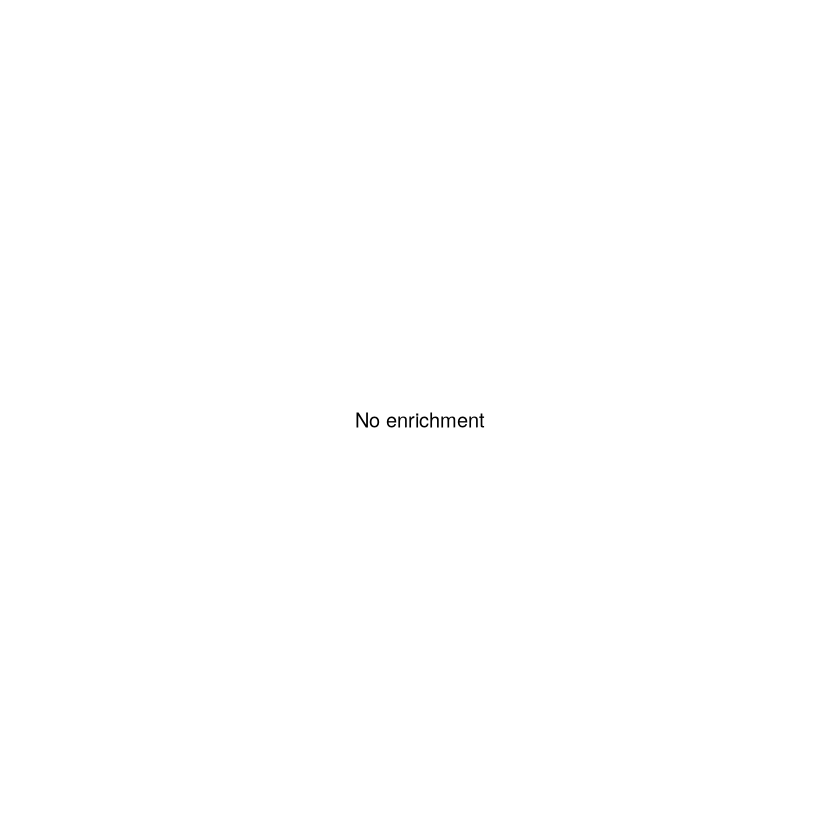

pdf 
  2

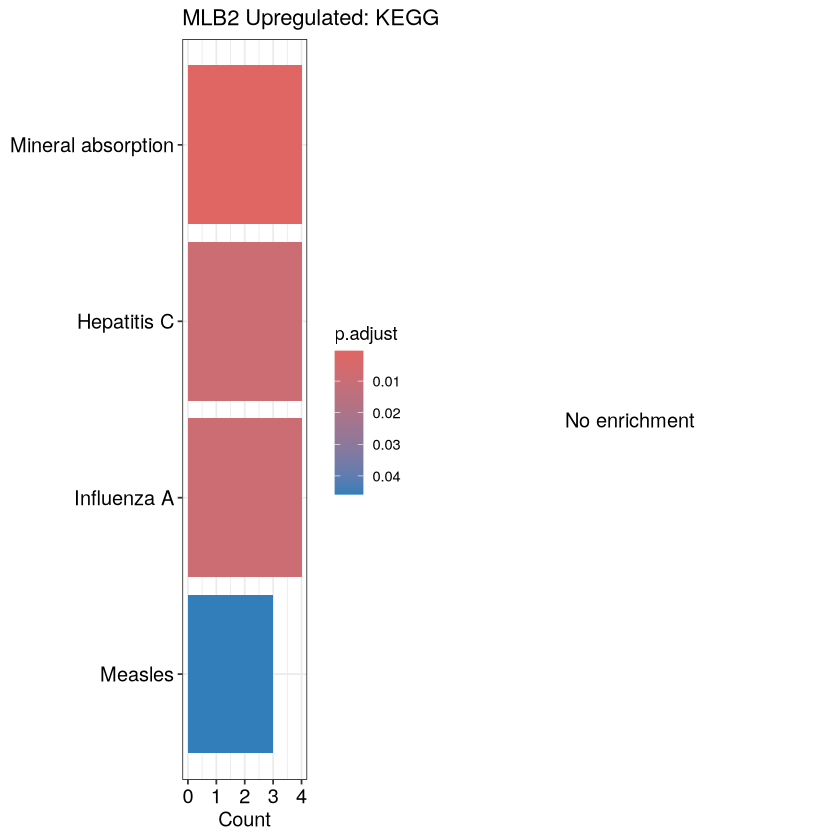

In [27]:
# Создаем barplot'ы (если уже созданы, просто переиспользуем)
plot_MLB2_up <- barplot(MLB2_kegg_up, showCategory = 10, title = "MLB2 Upregulated: KEGG")
plot_MLB2_down <- barplot(MLB2_kegg_down, showCategory = 10, title = "MLB2 Downregulated: KEGG")

# Если MLB2_down пуст — создаем заглушку
plot_MLB2_down <- grid.text("No enrichment", gp = gpar(fontsize = 12))

# Компоновка в сетку: по 2 графика в строке (up | down)
final_plot <- grid.arrange(
  arrangeGrob(plot_MLB2_up, plot_MLB2_down, ncol = 2),
  nrow = 1
)

# Сохранение в PDF
pdf("12_KEGG_barplots_Undiff354_MLB2.pdf", width = 14, height = 12)
grid.draw(final_plot)
dev.off()


# Reactome Pathway Enrichment (ReactomePA)

In [59]:
#BiocManager::install("ReactomePA")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'ReactomePA'

also installing the dependencies ‘viridis’, ‘tidygraph’, ‘graphlayouts’, ‘graph’, ‘ggraph’, ‘reactome.db’, ‘graphite’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'aplot', 'BiocManager', 'BiocParallel', 'bit', 'bit64', 'broom',
  'bslib', 'caret', 'cli', 'clock', 'cluster', 'commonmark', 'cpp11', 'curl',
  'data.table', 'DOSE', 'foreign', 'fs', 'future', 'future.apply', 'generics',
  'GenomeInfoDb', 'ggplot2', 'glmnet', 'globals', 'gower', 'hardhat', 'haven',
  'httpuv', 'httr2', 'jsonlite', 'knitr', 'later', 'lattice', 'locfit', 'maps',
  'MASS', 'Matrix', 'mgcv', 'mime', 'nlme', 'openssl', 'parallelly', 'pbdZMQ',
  'pheatmap', 'pillar',

In [61]:
ls()

[1] "deseq_b_HAstV4" "deseq_b_MLB2"   "deseq_b_VA1"    "deseq_results" 
 [5] "drgg"           "f"              "genes"          "gg"            
 [9] "merged"         "pccounts"       "plotPair"       "samples"       
[13] "t"              "t_df"           "t_transposed"   "z"

In [ ]:
#deseq_b_MLB2 = readRDS('../../rds/NGS-20250519/deg_0.05_1/deseq_brain_MLB2_mock.rds')
#deseq_b_VA1 = readRDS('../../rds/NGS-20250519/deg_0.05_1/deseq_brain_VA1_mock.rds')
#deseq_b_HAstV4 = readRDS('../../rds/NGS-20250519/deg_0.05_1/deseq_brain_HAstV4_mock_trypsin.rds')

In [34]:
library(ReactomePA)

# Reactome также требует ENTREZ ID — используем тот же MLB2_up_entrez
MLB2_reactome_up <- enrichPathway(gene         = MLB2_up_entrez$ENTREZID,
                               organism     = "human",
                               pAdjustMethod = "BH",
                               qvalueCutoff  = 0.05,
                               readable      = TRUE)

# Просмотр результатов
head(MLB2_reactome_up)

ReactomePA v1.50.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for
reactome pathway analysis and visualization. Molecular BioSystems.
2016, 12(2):477-479



,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-909733,R-HSA-909733,Interferon alpha/beta signaling,8/25,77/11146,0.10389610,46.32104,18.920349,3.515870e-12,3.234600e-10,2.627650e-10,IFIT2/MX1/IFIT3/USP18/RSAD2/OASL/OAS2/IFIT1,8
R-HSA-913531,R-HSA-913531,Interferon Signaling,9/25,269/11146,0.03345725,14.91658,10.954491,3.541785e-09,1.629221e-07,1.323509e-07,IFIT2/MX1/IFIT3/USP18/RSAD2/OASL/HERC5/OAS2/IFIT1,9
R-HSA-5661231,R-HSA-5661231,Metallothioneins bind metals,4/25,11/11146,0.36363636,162.12364,25.348286,6.426669e-09,1.970845e-07,1.601030e-07,MT1H/MT1E/MT1G/MT1X,4
R-HSA-5660526,R-HSA-5660526,Response to metal ions,4/25,14/11146,0.28571429,127.38286,22.433845,1.940617e-08,4.463420e-07,3.625890e-07,MT1H/MT1E/MT1G/MT1X,4
R-HSA-1169410,R-HSA-1169410,Antiviral mechanism by IFN-stimulated genes,6/25,149/11146,0.04026846,17.95329,9.877524,7.409227e-07,1.363298e-05,1.107485e-05,MX1/USP18/OASL/HERC5/OAS2/IFIT1,6
R-HSA-1169408,R-HSA-1169408,ISG15 antiviral mechanism,4/25,73/11146,0.05479452,24.42959,9.522074,1.930302e-05,2.959797e-04,2.404411e-04,MX1/USP18/HERC5/IFIT1,4


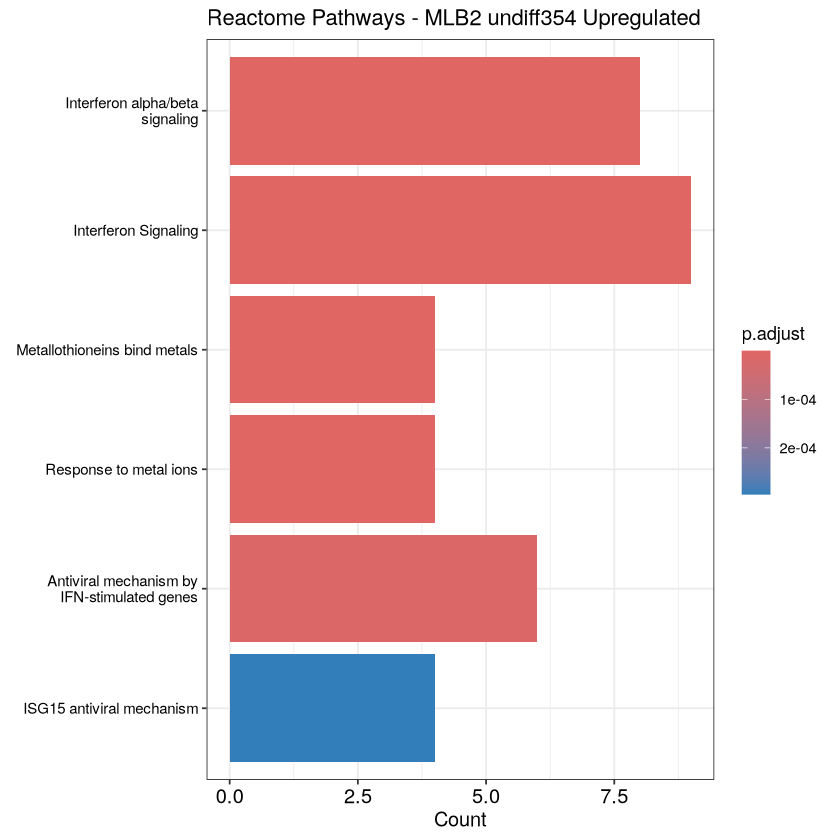

In [35]:
p1 = barplot(MLB2_reactome_up, showCategory = 15, title = "Reactome Pathways - MLB2 undiff354 Upregulated") +
  theme(axis.text.y = element_text(size = 9))  # или 7, если нужно еще меньше
p1

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'MLB2 Up Undiff354 – Reactome Membership Heatmap' in 'mbcsToSbcs': - substituted for – (U+2013)”


pdf 
  2

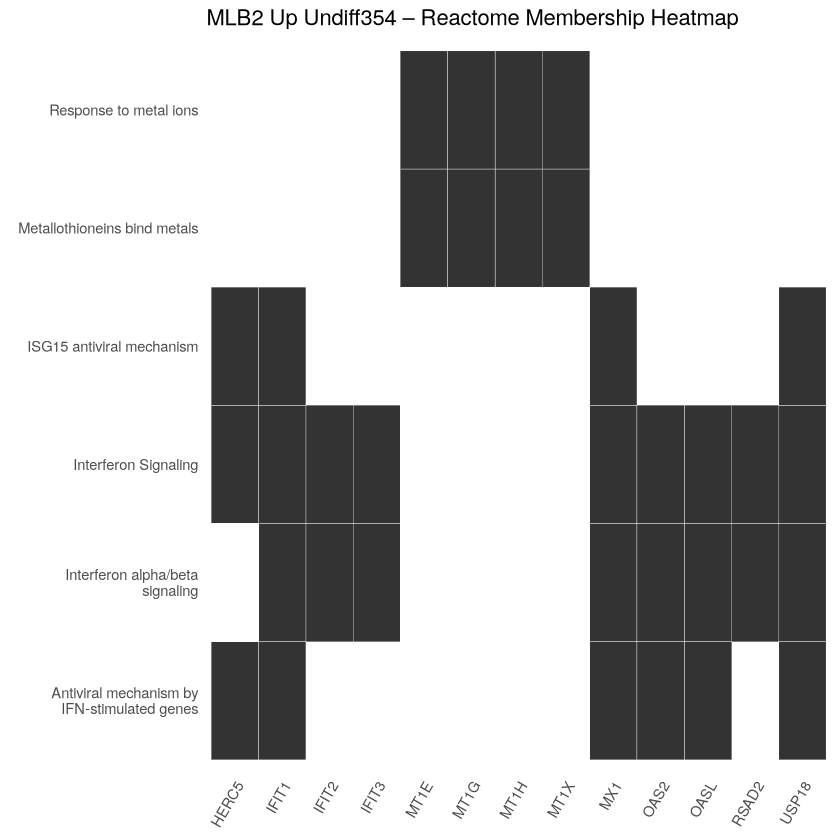

In [36]:
h1 = heatplot(MLB2_reactome_up, 
         showCategory = 10) +
  ggtitle("MLB2 Up Undiff354 – Reactome Membership Heatmap")
h1
pdf("13_REACTOME_heatplot_Gundiff_354_MLB2_Up.pdf", width = 16, height = 22)
grid.draw(h1)
dev.off()


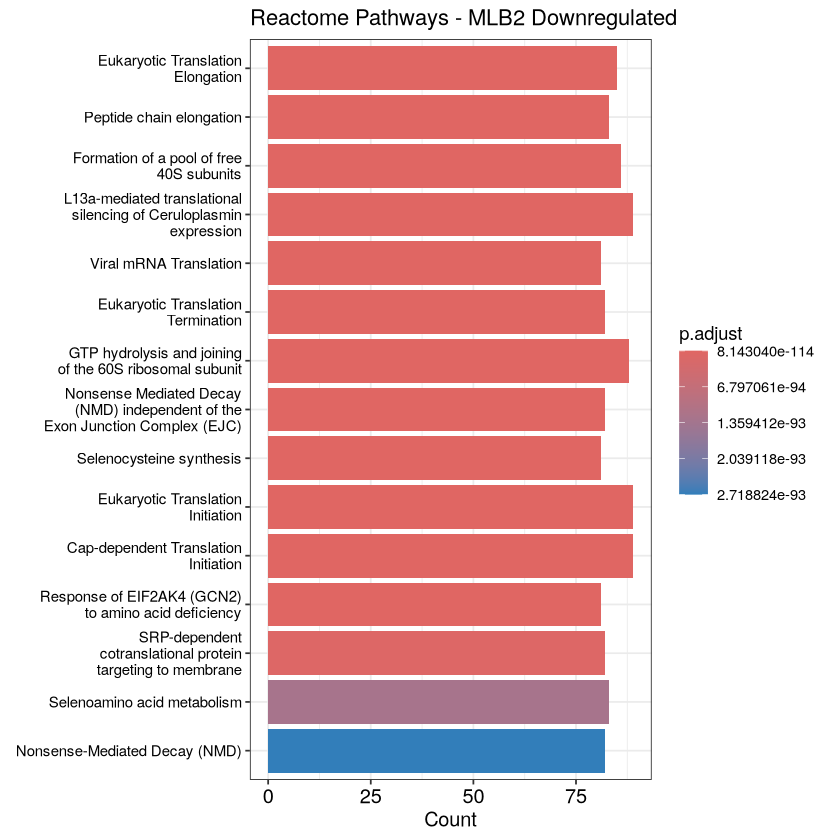

In [118]:
MLB2_reactome_down <- enrichPathway(gene         = MLB2_down_entrez$ENTREZID,
                               organism     = "human",
                               pAdjustMethod = "BH",
                               qvalueCutoff  = 0.05,
                               readable      = TRUE)

p2 = barplot(MLB2_reactome_down, showCategory = 15, title = "Reactome Pathways - MLB2 Downregulated") +
  theme(axis.text.y = element_text(size = 9)) 
p2

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'MLB2 Down – Reactome Membership Heatmap' in 'mbcsToSbcs': - substituted for – (U+2013)”


pdf 
  2

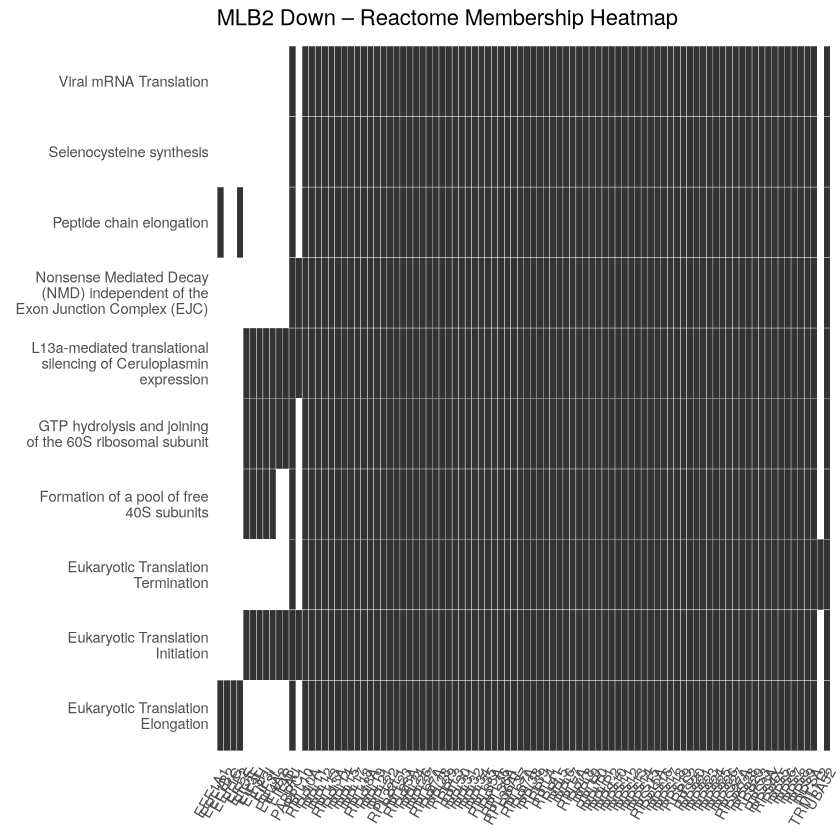

In [124]:
h2 = heatplot(MLB2_reactome_down, 
         showCategory = 10) +
  ggtitle("MLB2 Down – Reactome Membership Heatmap")
h2
pdf("13_REACTOME_heatplot_brain_10d_MLB2_Down.pdf", width = 16, height = 22)
grid.draw(h2)
dev.off()


In [112]:
VA1_reactome_up <- enrichPathway(gene         = VA1_up_entrez$ENTREZID,
                                 organism     = "human",
                                 pAdjustMethod = "BH",   # ← здесь исправлено
                                 qvalueCutoff  = 0.05,
                                 readable      = TRUE)

# Просмотр результатов
head(VA1_reactome_up)


,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-909733,R-HSA-909733,Interferon alpha/beta signaling,25/76,77/11146,0.32467532,47.61620,34.00956,7.640423e-37,2.979765e-34,2.493191e-34,SAMHD1/IFIT5/HLA-E/EIF2AK2/IFI27/HLA-B/USP18/IRF9/IFITM3/STAT1/HLA-C/HLA-A/PSMB8/BST2/ISG15/IFIT1/IFITM1/MX2/OASL/IFI6/IFIT3/IFIT2/MX1/OAS3/OAS1,25
R-HSA-913531,R-HSA-913531,Interferon Signaling,32/76,269/11146,0.11895911,17.44629,22.62365,2.886595e-32,5.628861e-30,4.709708e-30,TRIM5/SAMHD1/IFIT5/HLA-E/EIF2AK2/IFI27/TRIM22/TRIM25/HLA-B/USP18/IRF9/IFITM3/STAT1/HLA-C/RIGI/HERC5/HLA-A/B2M/SP100/PSMB8/BST2/ISG15/IFIT1/IFITM1/MX2/OASL/IFI6/IFIT3/IFIT2/MX1/OAS3/OAS1,32
R-HSA-877300,R-HSA-877300,Interferon gamma signaling,14/76,96/11146,0.14583333,21.38761,16.62240,2.061987e-15,2.680583e-13,2.242863e-13,TRIM5/HLA-E/TRIM22/TRIM25/HLA-B/IRF9/STAT1/HLA-C/HLA-A/B2M/SP100/OASL/OAS3/OAS1,14
R-HSA-1169410,R-HSA-1169410,Antiviral mechanism by IFN-stimulated genes,13/76,149/11146,0.08724832,12.79566,12.01022,1.903168e-11,1.855589e-09,1.552585e-09,EIF2AK2/TRIM25/USP18/STAT1/RIGI/HERC5/ISG15/IFIT1/MX2/OASL/MX1/OAS3/OAS1,13
R-HSA-1169408,R-HSA-1169408,ISG15 antiviral mechanism,10/76,73/11146,0.13698630,20.09012,13.55846,5.193395e-11,4.050848e-09,3.389374e-09,EIF2AK2/TRIM25/USP18/STAT1/RIGI/HERC5/ISG15/IFIT1/MX2/MX1,10
R-HSA-983170,R-HSA-983170,"Antigen Presentation: Folding, assembly and peptide loading of class I MHC",7/76,29/11146,0.24137931,35.40018,15.36876,7.153552e-10,4.649808e-08,3.890528e-08,TAP2/HLA-E/HLA-B/TAP1/HLA-C/HLA-A/B2M,7


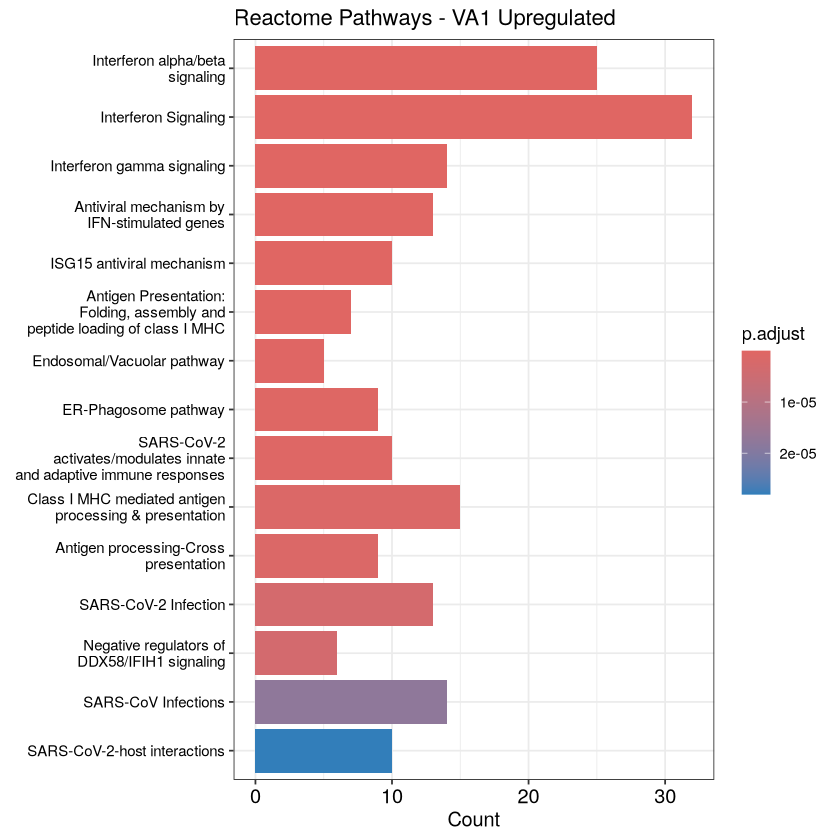

In [119]:
p3 = barplot(VA1_reactome_up, showCategory = 15, title = "Reactome Pathways - VA1 Upregulated") +
  theme(axis.text.y = element_text(size = 9))  # или 7, если нужно еще меньше
p3

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for 'VA1 Up – Reactome Membership Heatmap' in 'mbcsToSbcs': - substituted for – (U+2013)”


pdf 
  2

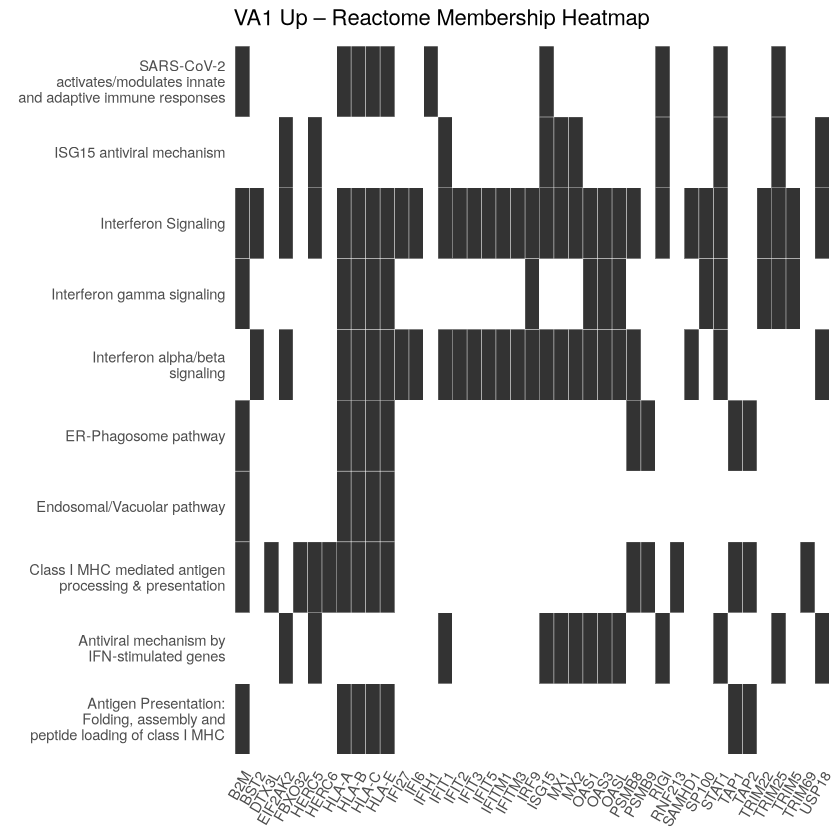

In [127]:
h3 = heatplot(VA1_reactome_up, 
         showCategory = 10) +
  ggtitle("VA1 Up – Reactome Membership Heatmap")
h3
pdf("13_REACTOME_heatplot_brain_10d_VA1_Up.pdf", width = 16, height = 22)
grid.draw(h3)
dev.off()


In [114]:
# Reactome-анализ
VA1_reactome_down <- enrichPathway(gene         = VA1_down_entrez$ENTREZID,
                                   organism     = "human",
                                   pAdjustMethod = "BH",
                                   qvalueCutoff  = 0.05,
                                   readable      = TRUE)

# Просмотр результатов
head(VA1_reactome_down)


ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>


In [115]:
p4 = barplot(VA1_reactome_down, showCategory = 15, title = "Reactome Pathways - VA1 Downregulated") +
  theme(axis.text.y = element_text(size = 10))  # или 7, если нужно еще меньше
p4

Warning message in rep(yes, length.out = len):
“'x' is NULL so the result will be NULL”
ERROR while rich displaying an object: Error in ans[ypos] <- rep(yes, length.out = len)[ypos]: replacement has length zero

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)

In [126]:
h4 = heatplot(VA1_reactome_down, 
         showCategory = 10) +
  ggtitle("VA1 Down – Reactome Membership Heatmap")
h4
pdf("13_REACTOME_heatplot_brain_10d_VA1_Down.pdf", width = 16, height = 22)
grid.draw(h4)
dev.off()


ERROR while rich displaying an object: Error in `geom_tile()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! object 'Gene' not found

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .   

ERROR: [1m[33mError[39m in `geom_tile()`:[22m
[1m[22m[33m![39m Problem while computing aesthetics.
[36mℹ[39m Error occurred in the 1st layer.
[1mCaused by error:[22m
[33m![39m object 'Gene' not found


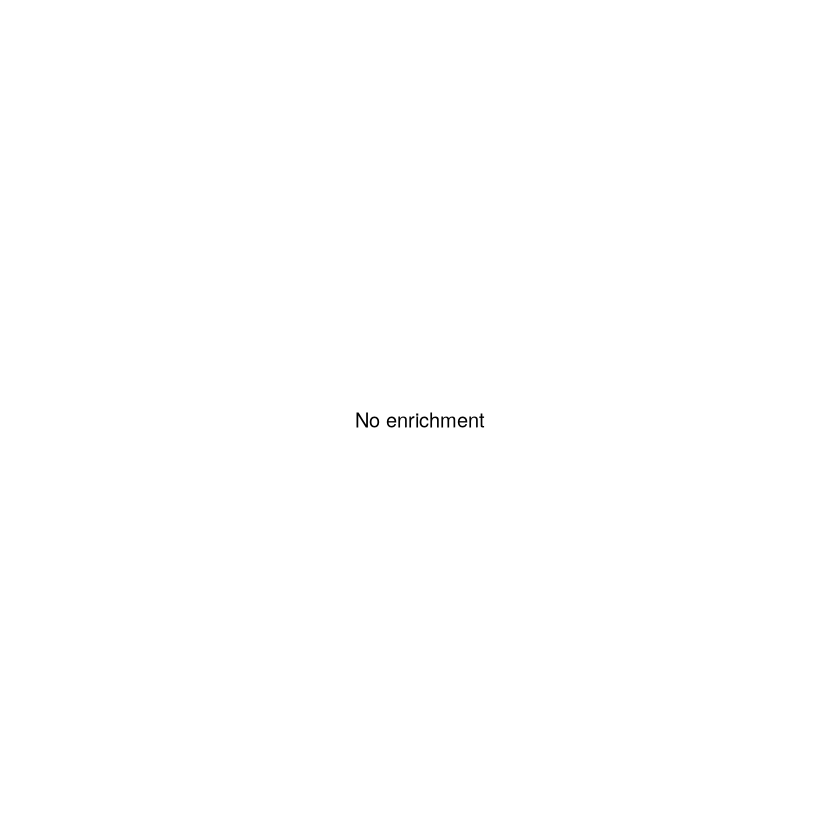

pdf 
  2

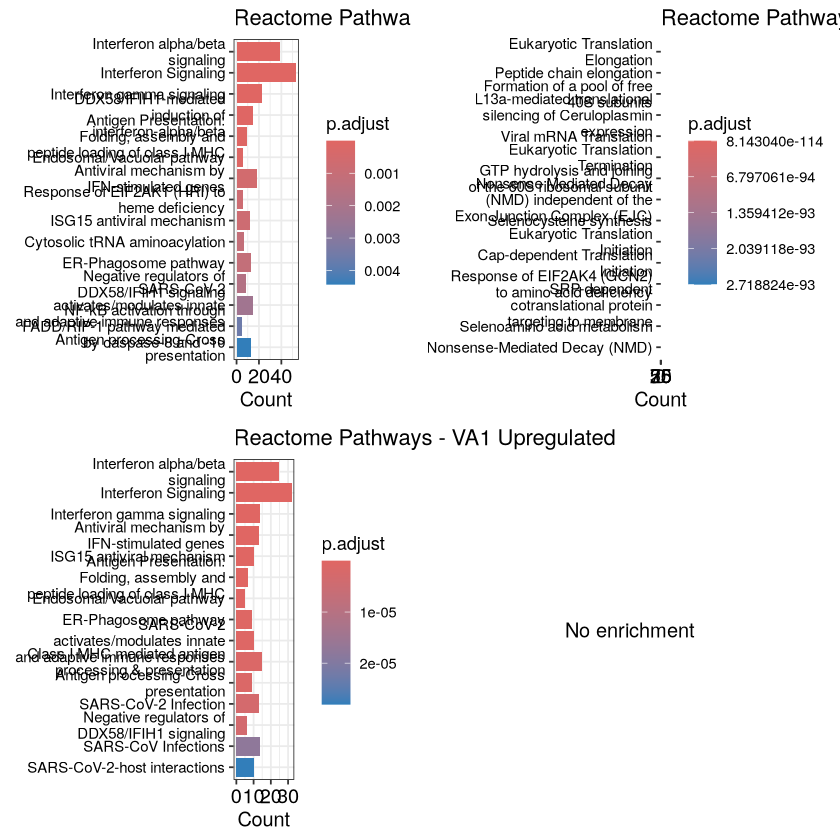

In [121]:
# Если VA1_down пуст — создаем заглушку
p4 <- grid.text("No enrichment", gp = gpar(fontsize = 12))

# Компоновка в сетку: по 2 графика в строке (up | down)
final_plot_Reactome <- grid.arrange(
  arrangeGrob(p1, p2, ncol = 2),
  arrangeGrob(p3, p4, ncol = 2),
  nrow = 2
)

# Сохранение в PDF
pdf("13_REACTOME_barplots_brain_10d.pdf", width = 16, height = 14)
grid.draw(final_plot_Reactome)
dev.off()
